# Automatic number plate detection
Authors : Akash Tiwari (229028), Rajat Tomar(229039)

### Loading necessary library

In [ ]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!pip install opencv-contrib-python
!pip install pytesseract
import os
import cv2
import io
from io import StringIO
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
drive.mount('/content/gdrive')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,266 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,342 kB]
Fetched 2,950 kB in 3s (878 kB/s)
Reading package list

### Downloading the dataset and creating the directory




In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aslanahmedov/number-plate-detection

100% 412M/413M [00:23<00:00, 15.0MB/s]
100% 413M/413M [00:23<00:00, 18.2MB/s]


In [ ]:
! mkdir /proj
! mkdir /proj/number-plate-detection
! mkdir /proj/number-plate-detection/train
! mkdir /proj/number-plate-detection/test

In [ ]:
! unzip /content/number-plate-detection.zip -d /tmp

Archive:  /content/number-plate-detection.zip
  inflating: /tmp/TEST/TEST.jpeg     
  inflating: /tmp/TEST/TEST.mp4      
  inflating: /tmp/data.yaml          
  inflating: /tmp/images/N1.jpeg     
  inflating: /tmp/images/N1.xml      
  inflating: /tmp/images/N100.jpeg   
  inflating: /tmp/images/N100.xml    
  inflating: /tmp/images/N101.jpeg   
  inflating: /tmp/images/N101.xml    
  inflating: /tmp/images/N102.jpeg   
  inflating: /tmp/images/N102.xml    
  inflating: /tmp/images/N103.jpeg   
  inflating: /tmp/images/N103.xml    
  inflating: /tmp/images/N104.jpeg   
  inflating: /tmp/images/N104.xml    
  inflating: /tmp/images/N105.jpeg   
  inflating: /tmp/images/N105.xml    
  inflating: /tmp/images/N106.jpeg   
  inflating: /tmp/images/N106.xml    
  inflating: /tmp/images/N107.jpeg   
  inflating: /tmp/images/N107.xml    
  inflating: /tmp/images/N108.jpeg   
  inflating: /tmp/images/N108.xml    
  inflating: /tmp/images/N109.jpeg   
  inflating: /tmp/images/N109.xml    
  in

In [ ]:
!cp -r /tmp/images/ /proj/number-plate-detection/train/
!cp -r /tmp/TEST/ /proj/number-plate-detection/test/

In [ ]:
import os
base_dir = '/proj/number-plate-detection/'
train_dir = os.path.join(base_dir,'train/images/')
test_dir= os.path.join(base_dir, 'test/TEST/')
num_tr = len(os.listdir(train_dir))
num_test = len(os.listdir(test_dir))
print("Total training Samples : ", num_tr)
print("Total test samples : ",num_test)
print("Total samples :",num_tr+num_test)

Total training Samples :  453
Total test samples :  2
Total samples : 455


## Data Preprocessing

#### Extracting bounding box coordinates from the train data

In [ ]:
path=glob(os.path.join(train_dir,'*.xml'))
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  /proj/number-plate-detection/train/images/N114...    15   200    33   126
1  /proj/number-plate-detection/train/images/N240...   164   285    99   137
2  /proj/number-plate-detection/train/images/N165...   186   374   290   335
3  /proj/number-plate-detection/train/images/N193...   274   502     2    59
4  /proj/number-plate-detection/train/images/N166...   809  1034   246   295

The above dataframe contains the filepath to the xml file, and bounding box coordinates xmin,xmax,ymin,ymax.

#### Extracting jpeg path for each image

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(train_dir,filename_image)
    return filepath_image
getFilename(filename)

'/proj/number-plate-detection/train/images/N114.jpeg'

From the dataframe created, for each xml file the getFilename function extracts the corresponding jpeg image path.


In [ ]:
image_path = list(df['filepath'].apply(getFilename)) #applying the getfilename funtion to the dataframe
image_path[:10] #Importing first ten image paths

['/proj/number-plate-detection/train/images/N114.jpeg',
 '/proj/number-plate-detection/train/images/N240.jpeg',
 '/proj/number-plate-detection/train/images/N165.jpeg',
 '/proj/number-plate-detection/train/images/N193.jpeg',
 '/proj/number-plate-detection/train/images/N166.jpeg',
 '/proj/number-plate-detection/train/images/N164.jpeg',
 '/proj/number-plate-detection/train/images/N100.jpeg',
 '/proj/number-plate-detection/train/images/N117.jpeg',
 '/proj/number-plate-detection/train/images/N226.jpeg',
 '/proj/number-plate-detection/train/images/N17.jpeg']

#### Displaying image along with the bounding box

In [ ]:
i=34 #index of the image
file_path = image_path[i]
xml_path = file_path.split('.')[0]+'.xml'
bb=df[df['filepath']==xml_path]
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=bb.xmin[i], x1=bb.xmax[i], y0=bb.ymin[i], y1=bb.ymax[i], xref='x', yref='y',line_color='gold')

In the above image we can see the car number plate bounded by a yellow box. All the images in train folder have corresponding coordinates of the bounding boxes which will be used to detect number plates in unseen images.

## Image preprocessing

In [ ]:
labels = df.iloc[:,1:].values # extracting coordinates for all the bounding boxes.
data = []  # list to hold the data that we will give to the input layer.
output = [] # list to hold the target vector to be used for evaluating the training the model.
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)


We have normalized the image by dividing with maximum number for an 8-bit image is 28 -1 = 255. This way of dividing an array with the maximum value is called Normalization. We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. For normalizing labels, we need to divide the diagonal points with the width and height of the image. Once the normalization is done we have appended the data to the list.

In [ ]:
# convert the list into an array using Numpy.
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

#### Splitting into train and test data

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

## DEEP LEARNING FOR OBJECT DETECTION

### Xception
Xception, short for "Extreme Inception," is a deep convolutional neural network (CNN) architecture that was introduced by François Chollet in 2016. It is designed for image classification tasks and is a notable variant of the Inception architecture. What sets Xception apart from traditional CNNs is its unique approach to handling convolutional layers. Instead of using standard convolutional layers with filters of fixed sizes, Xception employs depthwise separable convolutions.

![Xception layers](https://drive.google.com/uc?export=view&id=128IbHO_cG7I6h7z1R_647EDTSuBiCixx)

In Xception, each convolution operation is broken down into two separate steps: depthwise convolution and pointwise convolution. Depthwise convolution applies a separate 3x3 convolution to each channel of the input, while pointwise convolution combines the outputs of the depthwise convolution using 1x1 convolutions. This separation of spatial and channel-wise information allows Xception to efficiently capture complex patterns and reduce the number of parameters compared to traditional CNNs. As a result, Xception achieves impressive performance on various computer vision tasks while being computationally efficient. It has been widely used in applications such as image classification, object detection, and image segmentation, and it has become a foundational architecture for modern deep learning models in computer vision.

![Xception architecture](https://drive.google.com/uc?export=view&id=1RnF4LmtYWHElGOdewXY311rQCwrXdv4t)


In [ ]:
from tensorflow.keras.applications import Xception
xcep_model = Xception(include_top=False, weights='imagenet', input_shape = (224, 224 , 3))

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
headmodel = xcep_model.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512,activation="relu")(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
model = Model(inputs=xcep_model.input,outputs=headmodel)

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 15, verbose = 1, factor = 0.1, min_lr = 0.0000001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb,callbacks])

Epoch 1/100
18/18 [==============================] - 46s 287ms/step - loss: 0.0463 - val_loss: 0.0345 - lr: 1.0000e-04
Epoch 2/100
18/18 [==============================] - 3s 171ms/step - loss: 0.0164 - val_loss: 0.0249 - lr: 1.0000e-04
Epoch 3/100
18/18 [==============================] - 3s 164ms/step - loss: 0.0097 - val_loss: 0.0216 - lr: 1.0000e-04
Epoch 4/100
18/18 [==============================] - 3s 173ms/step - loss: 0.0061 - val_loss: 0.0199 - lr: 1.0000e-04
Epoch 5/100
18/18 [==============================] - 3s 176ms/step - loss: 0.0053 - val_loss: 0.0112 - lr: 1.0000e-04
Epoch 6/100
18/18 [==============================] - 3s 173ms/step - loss: 0.0050 - val_loss: 0.0114 - lr: 1.0000e-04
Epoch 7/100
18/18 [==============================] - 3s 167ms/step - loss: 0.0039 - val_loss: 0.0095 - lr: 1.0000e-04
Epoch 8/100
18/18 [==============================] - 3s 174ms/step - loss: 0.0025 - val_loss: 0.0104 - lr: 1.0000e-04
Epoch 9/100
18/18 [==============================] - 3s

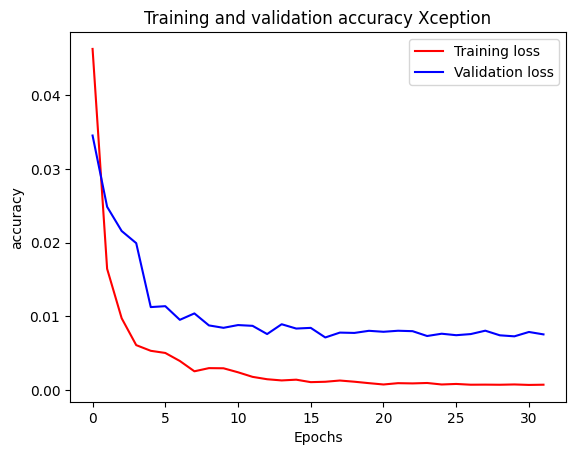

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy Xception')
plt.legend(loc=0)
plt.figure()

plt.show()

#### Inception resnet model
Inception-ResNet is a fusion of two influential deep learning architectures: GoogLeNet's Inception module and Residual Networks (ResNets). This hybrid architecture was designed to address the challenge of training very deep neural networks while maintaining computational efficiency and improving model performance. In the context of object detection, Inception-ResNet serves as a backbone network, providing feature extraction capabilities that are crucial for detecting objects within images.

![Inception resnet architecture](https://drive.google.com/uc?export=view&id=1fXrUilAgKYqW_qOY5synmj3G-SYHrPv7)

The Inception-ResNet architecture achieves its effectiveness by combining the strengths of both Inception and ResNet modules. Inception modules are known for their ability to capture multi-scale features efficiently through the use of various filter sizes, while ResNet's skip connections enable the training of very deep networks by mitigating the vanishing gradient problem. Inception-ResNet integrates these two concepts by inserting residual connections within Inception modules, allowing for both feature diversity and gradient flow. This results in a network that can be deeper, more accurate, and computationally efficient for object detection tasks, making it a popular choice as the backbone architecture in modern object detection models like Faster R-CNN and Mask R-CNN.

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
model1 = Model(inputs=inception_resnet.input,outputs=headmodel)
# Complie model

model1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model1.summary()

tfb = TensorBoard('object_detection')
history2 = model1.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb,callbacks])

219055592/219055592 [==============================] - 11s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 111, 111, 32)         96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)

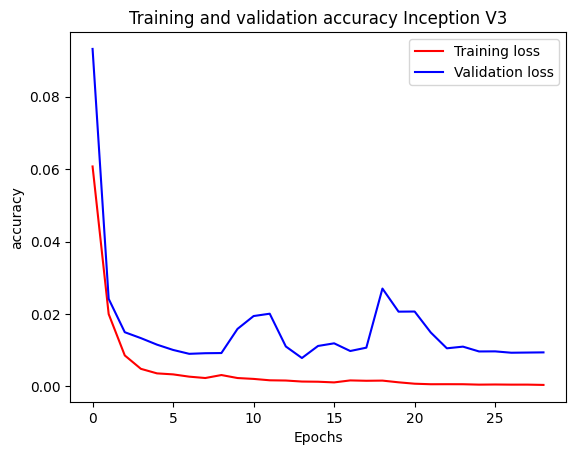

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy Inception V3')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/number_plate_detection_xcep.keras')
model1.save('/content/gdrive/MyDrive/number_plate_detection_incepresnet.keras')

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/number_plate_detection_xcep.keras')
print('Model loaded Sucessfully')
model1 = tf.keras.models.load_model('/content/gdrive/MyDrive/number_plate_detection_incepresnet.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully
Model loaded Sucessfully


In [ ]:
# Create pipeline
path = '/proj/number-plate-detection/test/TEST/TEST.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 1s 1s/step
(314, 509) (580, 563)


In [ ]:
# Create pipeline
path = '/proj/number-plate-detection/test/TEST/TEST.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model1.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 4s 4s/step
(351, 483) (581, 538)


In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

‘L 51 K 4999



In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/proj/number-plate-detection/train/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  /proj/number-plate-detection/train/images/N114...    15   200    33   126   
1  /proj/number-plate-detection/train/images/N240...   164   285    99   137   
2  /proj/number-plate-detection/train/images/N165...   186   374   290   335   
3  /proj/number-plate-detection/train/images/N193...   274   502     2    59   
4  /proj/number-plate-detection/train/images/N166...   809  1034   246   295   

                                            filename  width  height  
0  /proj/number-plate-detection/train/images/N114...    250     166  
1  /proj/number-plate-detection/train/images/N240...    500     306  
2  /proj/number-plate-detection/train/images/N165...    588     476  
3  /proj/number-plate-detection/train/images/N193...    802     615  
4  /proj/number-plate-detection/train/images/N166...   1266     453

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  /proj/number-plate-detection/train/images/N114...    15   200    33   126   
1  /proj/number-plate-detection/train/images/N240...   164   285    99   137   
2  /proj/number-plate-detection/train/images/N165...   186   374   290   335   
3  /proj/number-plate-detection/train/images/N193...   274   502     2    59   
4  /proj/number-plate-detection/train/images/N166...   809  1034   246   295   

                                            filename  width  height  center_x  \
0  /proj/number-plate-detection/train/images/N114...    250     166  0.430000   
1  /proj/number-plate-detection/train/images/N240...    500     306  0.449000   
2  /proj/number-plate-detection/train/images/N165...    588     476  0.476190   
3  /proj/number-plate-detection/train/images/N193...    802     615  0.483791   
4  /proj/number-plate-detection/train/images/N166...   1266     453  0.727883   

   center_y  bb_width  bb_height  
0  0.478916  0.740000   0.560241  
1  0.385621  0.242000   0.124183  
2  0.656513  0.319728   0.094538  
3  0.049593  0.284289   0.092683  
4  0.597130  0.177725   0.108168

### YOLO Algorithm for Object Detection
The YOLO (You Only Look Once) architecture for object detection is known for its efficiency and speed. It processes an input image through a convolutional neural network (CNN) to generate feature maps that capture information at different scales. These feature maps are divided into a grid of cells, and each cell predicts multiple bounding boxes (anchor boxes) for potential objects. YOLO simultaneously predicts the presence of objects, their class probabilities, and the coordinates of the bounding boxes relative to each cell. This unique approach enables YOLO to perform object detection in a single pass through the network, making it highly efficient and suitable for real-time applications. Furthermore, YOLO employs post-processing techniques like non-maximum suppression (NMS) to filter and refine the final set of detected objects, eliminating duplicate and low-confidence detections. YOLO's ability to achieve a good balance between speed and accuracy has made it a popular choice in various computer vision applications, including autonomous vehicles, surveillance, and robotics.
![Yolo](https://drive.google.com/uc?export=view&id=1l0_wFSU1oIPsI-sUCt19bDQ9RSBEnvD0)

Over the years, YOLO has undergone several iterations, with each version bringing improvements in performance and accuracy. YOLOv4, for instance, introduced architectural enhancements and optimizations, making it one of the state-of-the-art models for object detection. The YOLO architecture's ability to handle real-time object detection tasks efficiently has cemented its reputation as a groundbreaking approach in the field of computer vision, making it a go-to choice for many applications that require fast and accurate object detection.

![Yolo](https://drive.google.com/uc?export=view&id=1zn9kGDbLjkImUh_C0w2Uyd-XAsqqpKW-)

In [ ]:
!git clone https://github.com/ultralytics/yolov5 #cloning the model directory from github

Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.60 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (10987/10987), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt #installing the required library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.4/617.4 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
#creating directories for train and test data
!mkdir ./yolov5/data_images/
!mkdir ./yolov5/data_images/test/
!mkdir ./yolov5/data_images/train/

In [ ]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [ ]:
df_train

filepath  xmin  xmax  ymin  \
0    /proj/number-plate-detection/train/images/N114...    15   200    33   
1    /proj/number-plate-detection/train/images/N240...   164   285    99   
2    /proj/number-plate-detection/train/images/N165...   186   374   290   
3    /proj/number-plate-detection/train/images/N193...   274   502     2   
4    /proj/number-plate-detection/train/images/N166...   809  1034   246   
..                                                 ...   ...   ...   ...   
195  /proj/number-plate-detection/train/images/N220...   182   349   238   
196  /proj/number-plate-detection/train/images/N206...   121   215   120   
197  /proj/number-plate-detection/train/images/N169...   167   413   208   
198  /proj/number-plate-detection/train/images/N138...    36   465    64   
199  /proj/number-plate-detection/train/images/N86.xml   448   638   273   

     ymax                                           filename  width  height  \
0     126  /proj/number-plate-detection/train/images/N114...    250     166   
1     137  /proj/number-plate-detection/train/images/N240...    500     306   
2     335  /proj/number-plate-detection/train/images/N165...    588     476   
3      59  /proj/number-plate-detection/train/images/N193...    802     615   
4     295  /proj/number-plate-detection/train/images/N166...   1266     453   
..    ...                                                ...    ...     ...   
195   273  /proj/number-plate-detection/train/images/N220...    500     366   
196   147  /proj/number-plate-detection/train/images/N206...    317     215   
197   263  /proj/number-plate-detection/train/images/N169...    600     361   
198   168  /proj/number-plate-detection/train/images/N138...    480     360   
199   338  /proj/number-plate-detection/train/images/N86....    640     555   

     center_x  center_y  bb_width  bb_height  
0    0.430000  0.478916  0.740000   0.560241  
1    0.449000  0.385621  0.242000   0.124183  
2    0.476190  0.656513  0.319728   0.094538  
3    0.483791  0.049593  0.284289   0.092683  
4    0.727883  0.597130  0.177725   0.108168  
..        ...       ...       ...        ...  
195  0.531000  0.698087  0.334000   0.095628  
196  0.529968  0.620930  0.296530   0.125581  
197  0.483333  0.652355  0.410000   0.152355  
198  0.521875  0.322222  0.893750   0.288889  
199  0.848437  0.550450  0.296875   0.117117  

[200 rows x 12 columns]

### Preparing train and test data for yolo

In [ ]:
#train folder path
train_folder = './yolov5/data_images/train/'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values  #extracting image path and corresponding bounding box dimensions
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name) #image path in the training folder
    dst_label_file = os.path.join(train_folder,txt_name+'.txt') # path for the labels in training folder

    # copy each image into the folder
    copy(fname,dst_image_path) #copying images into the training folder

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

#test folder path
test_folder = './yolov5/data_images/test/'

#Repeating the same steps for test folder
values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

### GPU memory management

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache() #clears the GPU memory cache used by PyTorch

    cuda.select_device(0)  #selects the GPU device with index 0.
    cuda.close()           #closes the currently selected GPU device, releasing any resources associated with it.
    cuda.select_device(0)  #selects the GPU device again, which can help ensure that the GPU resources are properly released.

    print("GPU Usage after emptying the cache")
    gpu_usage() #check after performing the cache clearing and cleanup operations

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=02e8dda04ef06ec746f8c0db7cb5d6920a12446ce4971ed9468c9d9e18d305ce
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 87% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 61% |  1% |


## YOLOv5 architecture

1. **Layer 0: Convolutional Layer**
   - Type: Convolutional layer
   - Input: 3 channels (RGB image)
   - Output: 32 channels
   - Kernel Size: 6x6
   - Stride: 2
   - Padding: 2
   - Total Parameters: 3,520

2. **Layer 1: Convolutional Layer**
   - Type: Convolutional layer
   - Input: 32 channels
   - Output: 64 channels
   - Kernel Size: 3x3
   - Stride: 2
   - Total Parameters: 18,560

3. **Layer 2: C3 Layer**
   - Type: Custom C3 layer
   - Input: 64 channels
   - Output: 64 channels
   - Number of Sub-Layers: 1
   - Total Parameters: 18,816

4. **Layer 3: Convolutional Layer**
   - Type: Convolutional layer
   - Input: 64 channels
   - Output: 128 channels
   - Kernel Size: 3x3
   - Stride: 2
   - Total Parameters: 73,984

5. **Layer 4: C3 Layer**
   - Type: Custom C3 layer
   - Input: 128 channels
   - Output: 128 channels
   - Number of Sub-Layers: 2
   - Total Parameters: 115,712

6. **Layer 5: Convolutional Layer**
   - Type: Convolutional layer
   - Input: 128 channels
   - Output: 256 channels
   - Kernel Size: 3x3
   - Stride: 2
   - Total Parameters: 295,424

7. **Layer 6: C3 Layer**
   - Type: Custom C3 layer
   - Input: 256 channels
   - Output: 256 channels
   - Number of Sub-Layers: 3
   - Total Parameters: 625,152

8. **Layer 7: Convolutional Layer**
   - Type: Convolutional layer
   - Input: 256 channels
   - Output: 512 channels
   - Kernel Size: 3x3
   - Stride: 2
   - Total Parameters: 1,180,672

9. **Layer 8: C3 Layer**
   - Type: Custom C3 layer
   - Input: 512 channels
   - Output: 512 channels
   - Number of Sub-Layers: 1
   - Total Parameters: 1,182,720

10. **Layer 9: SPPF Layer**
    - Type: Spatial Pyramid Pooling with FPN (Feature Pyramid Network)
    - Input: 512 channels
    - Output: 512 channels
    - Total Parameters: 656,896

11. **Layer 10: Convolutional Layer**
    - Type: Convolutional layer
    - Input: 512 channels
    - Output: 256 channels
    - Kernel Size: 1x1
    - Total Parameters: 131,584

12. **Layer 11: Upsampling Layer**
    - Type: Upsampling layer
    - Upsample Factor: 2 (nearest-neighbor upsampling)

13. **Layer 12: Concatenation Layer**
    - Type: Concatenation layer
    - Input: Combines the output of the previous Convolutional Layer (Layer 10) with a previous layer specified as `[1]`.

14. **Layer 13: C3 Layer**
    - Type: Custom C3 layer
    - Input: 256 channels
    - Output: 256 channels
    - Number of Sub-Layers: 1
    - Total Parameters: 361,984

15. **Layer 14: Convolutional Layer**
    - Type: Convolutional layer
    - Input: 256 channels
    - Output: 128 channels
    - Kernel Size: 1x1
    - Total Parameters: 33,024

16. **Layer 15: Upsampling Layer**
    - Type: Upsampling layer
    - Upsample Factor: 2 (nearest-neighbor upsampling)

17. **Layer 16: Concatenation Layer**
    - Type: Concatenation layer
    - Input: Combines the output of the previous Convolutional Layer (Layer 14) with a previous layer specified as `[1]`.

18. **Layer 17: C3 Layer**
    - Type: Custom C3 layer
    - Input: 256 channels
    - Output: 128 channels
    - Number of Sub-Layers: 1
    - Total Parameters: 90,880

19. **Layer 18: Convolutional Layer**
    - Type: Convolutional layer
    - Input: 128 channels
    - Output: 128 channels
    - Kernel Size: 3x3
    - Stride: 2
    - Total Parameters: 147,712

20. **Layer 19: Concatenation Layer**
    - Type: Concatenation layer
    - Input: Combines the output of the previous Convolutional Layer (Layer 18) with a previous layer specified as `[1]`.

21. **Layer 20: C3 Layer**
    - Type: Custom C3 layer
    - Input: 256 channels
    - Output: 256 channels
    - Number of Sub-Layers: 1
    - Total Parameters: 296,448

22. **Layer 21: Convolutional Layer**
    - Type: Convolutional layer
    - Input: 256 channels
    - Output: 256 channels
    - Kernel Size: 3x3
    - Stride: 2
    - Total Parameters: 590,336

23. **Layer 22: Concatenation Layer**
    - Type: Concatenation layer
    - Input: Combines the output of the previous Convolutional Layer (Layer 21) with a previous layer specified as `[1]`.

24. **Layer 23: C3 Layer**
    - Type: Custom C3 layer
    - Input: 512 channels
    - Output: 512 channels
    - Number of Sub-Layers: 1
    - Total Parameters: 1,182,720

25. **Layer 24: Detection Layer**
    - Type: Detection layer
    - Number of Classes: 1 (single-class detection)
    - Anchor Boxes: Three sets of anchor boxes with different dimensions
    - Output Sizes: 128x128, 256x256, and 512x512 feature maps
    - Total Parameters: 16,182

This architecture is designed for object detection tasks, where it takes an input image and produces multiple feature maps of different resolutions (scales). The final detection layer is responsible for predicting bounding

### Training the model

In [ ]:
!python ./yolov5/train.py --data /tmp/data.yaml  --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=/tmp/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=

In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx # saving the model as torchscript and onnx file

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.0.1+cu118...
TorchScript: export success ✅ 3.3s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 118.2 MB/s eta 0:00:00


### Loading the trained model

In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Testing the model performance on unseen images

In [ ]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640
# Function for extracting text from the bounding box
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return 'no number'

    else:
        text = pt.image_to_string(roi)
        text = text.strip()

        return text

# CONVERT IMAGE TO YOLO FORMAT AND GET PREDICTIONS
def get_detections(img,net):
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image  #copies the original image into the top-left portion of the output image, padding the rest with zeros

    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False) #prepares the image (input_image) to be fed into the YOLO model
    net.setInput(blob)    # feeds the image to the input layer
    preds = net.forward() #obtaining predictions
    detections = preds[0]

    return input_image, detections

# FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
def non_maximum_supression(input_image,detections):

    boxes = []        # List to store detected bounding boxes
    confidences = []  # List to store detection confidences (confidence scores)


    image_w, image_h = input_image.shape[:2]
    x_factor = image_w / INPUT_WIDTH  # Scaling factor for x-coordinate
    y_factor = image_h / INPUT_HEIGHT # Scaling factor for y-coordinate

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                  cx, cy, w, h = row[0:4]  # Center coordinates (cx, cy), width (w), and height (h) of the bounding box
                  left = int((cx - 0.5 * w) * x_factor)  # Left coordinate of the bounding box
                  top = int((cy - 0.5 * h) * y_factor)   # Top coordinate of the bounding box
                  width = int(w * x_factor)              # Scaled width of the bounding box
                  height = int(h * y_factor)            # Scaled height of the bounding box
                  box = np.array([left, top, width, height])  # Create a bounding box array

                  confidences.append(confidence)  # Store confidence score
                  boxes.append(box)              # Store the bounding box


    # CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45) #removes duplicate or overlapping bounding boxes and keeps the most confident ones.

    return boxes_np, confidences_np, index

# Drawing the bouding box
def drawings(image,boxes_np,confidences_np,index):
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image, conf_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)  # Increase font size and thickness
        cv2.putText(image, license_text, (x, y+h+27), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)  # Increase font size and thickness


    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

### Model performance on test image

In [ ]:
img = io.imread('/proj/number-plate-detection/test/TEST/TEST.jpeg')
results = yolo_predictions(img,net)
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

### Model performance on a ramdom image

In [ ]:
# test
sample = io.imread('/content/gdrive/MyDrive/photo-1504381270825-025726abb1de.jpg')
results = yolo_predictions(sample,net)
fig = px.imshow(sample)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

## Conclusion

Yolov5 successfully identifies license number plates not only in train and test data, but also on images that have been downloaded and the model has never seen earlier.

This success can be attributed to the architecture's unique characteristics. YOLOv5 excels by predicting both the object's center and its dimensions through multiple bounding boxes, facilitating highly accurate object detection. Additionally, the model provides crucial evaluation metrics such as precision (P), recall (R), mean average precision at 50% intersection over union (mAP50), and mean average precision from 50% to 95% intersection over union (mAP50-95) for each class in every epoch. These metrics enable the model to fine-tune anchor boxes effectively, further improving accuracy. Furthermore, the incorporation of Non-Maximum Suppression ensures that only the most relevant bounding boxes are retained, significantly enhancing the overall quality of predictions.

In conclusion, YOLOv5's exceptional performance in license plate detection can be attributed to its unique architectural features, robust evaluation metrics, and the implementation of Non-Maximum Suppression. These factors collectively enable YOLOv5 to outperform other object detection algorithms, particularly when it comes to accurately identifying license plates in diverse, real-world scenarios.
